# Estimate haplotype ages

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

### Data setup 

In [2]:
# load data
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [3]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [4]:
collections.Counter(ann['Annotation'])

Counter({b'3_prime_UTR_variant': 5987,
         b'5_prime_UTR_premature_start_codon_': 494,
         b'5_prime_UTR_variant': 2971,
         b'downstream_gene_variant': 41916,
         b'initiator_codon_variant': 5,
         b'intergenic_region': 102204,
         b'intragenic_variant': 48,
         b'intron_variant': 77277,
         b'missense_variant': 12387,
         b'missense_variant&splice_region_var': 160,
         b'splice_acceptor_variant&intron_var': 45,
         b'splice_donor_variant&intron_varian': 50,
         b'splice_region_variant': 70,
         b'splice_region_variant&intron_varia': 1448,
         b'splice_region_variant&stop_retaine': 11,
         b'splice_region_variant&synonymous_v': 207,
         b'start_lost': 15,
         b'stop_gained': 85,
         b'stop_gained&splice_region_variant': 1,
         b'stop_lost': 2,
         b'stop_lost&splice_region_variant': 9,
         b'stop_retained_variant': 9,
         b'synonymous_variant': 19507,
         b'upstream_gene_

In [5]:
# perform allele count - needed to locate singletons  
ac = haps.count_alleles(max_allele=3)
ac[:1]

,0,1,2,3
0,1529,1,0,0


### Setup missense variation

In [6]:
tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|SNPEFF_CDS_pos,26|AF_AOM,27|AF_BFM,28|AF_GWA,29|AF_GNS,30|AF_BFS,31|AF_CMS,32|AF_GAS,33|AF_UGS,34|AF_KES,35|check_allele,36|exon_start,37|exon_end,38|exon,39|AGAP004707-RA,40|AGAP004707-RB,41|AGAP004707-RC,42|Davies-C1N2,43|Davies-C3N2,44|Davies-C5N2,45|Davies-C7N2,46|Davies-C8N2,47|Davies-C10N2,48|Davies-C11N2,49|Davies-C1N9,50|Davies-C8N9,51|Davies-C1N9ck
2L,2390177,2,G,A,198,0,True,0,3,8,0,0,False,False,False,0.12695,1,18.625,0.83496,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,761,0.0,0.0,0.0,0.0,0.0,0.316363636364,0.214285714286,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K
2L,2391228,3,G,C,10,0,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,1204,0.0,0.0724637681159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2391228,3,G,T,9,1,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,None,None,None,None,None,None,0.0,0.0652173913043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2399997,2,G,C,38,0,True,0,1,7,0,0,False,False,False,13.359,0,15.688,0.11798,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,1396,0.0,0.0,0.0,0.0,0.0,0.0690909090909,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H
2L,2400071,3,G,A,16,0,True,0,0,8,0,0,False,False,False,5.6875,0,16.969,1.3232,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818181818,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I


In [7]:
tbl_selected_redux = (
    tbl_variants_selected
    .cut('POS', 'REF', 'ALT', 'AGAP004707-RA')
    .mergeduplicates(key=('POS'))
    .convert('ALT', lambda v: ','.join(v) if len(v) > 1 else v)
    .addfield('label',  lambda rec: '%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT.ljust(3), rec['AGAP004707-RA'].rjust(6)))
    .sort('POS')
)
tbl_selected_redux.display(vrepr=repr)

0|POS,1|REF,2|ALT,3|AGAP004707-RA,4|label
2390177,'G','A','R254K','2390177:G>A R254K'
2391228,'G',"'C,T'",'V402L',"'2391228:G>C,T V402L'"
2399997,'G','C','D466H','2399997:G>C D466H'
2400071,'G',"'A,T'",'M490I',"'2400071:G>A,T M490I'"
2416980,'C','T','T791M','2416980:C>T T791M'


In [8]:
lbl_vgsc_missense = tbl_selected_redux.values('label').list()
lbl_vgsc_missense

['2390177:G>A    R254K',
 '2391228:G>C,T  V402L',
 '2399997:G>C    D466H',
 '2400071:G>A,T  M490I',
 '2416980:C>T    T791M',
 '2422651:T>C    L995S',
 '2422652:A>T    L995F',
 '2424384:C>T   A1125V',
 '2425077:G>A   V1254I',
 '2429617:T>C   I1527T',
 '2429745:A>T   N1570Y',
 '2429897:A>G   E1597G',
 '2429915:A>C   K1603T',
 '2430424:G>T   A1746S',
 '2430817:G>A   V1853I',
 '2430863:T>C   I1868T',
 '2430880:C>T   P1874S',
 '2430881:C>T   P1874L',
 '2431019:T>C   F1920S',
 '2431061:C>T   A1934V',
 '2431079:T>C   I1940T']

In [9]:
pos_selected = tbl_selected_redux.values('POS').array()
pos_selected

array([2390177, 2391228, 2399997, 2400071, 2416980, 2422651, 2422652,
       2424384, 2425077, 2429617, 2429745, 2429897, 2429915, 2430424,
       2430817, 2430863, 2430880, 2430881, 2431019, 2431061, 2431079], dtype=int32)

In [10]:
loc_vgsc_missense = pos.locate_keys(pos_selected)
np.count_nonzero(loc_vgsc_missense)

21

In [11]:
haps_vgsc_missense = haps[loc_vgsc_missense]
haps_vgsc_missense

<HaplotypeArray shape=(21, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 2 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

## Split up haplotype data into neutral/mutation

Here we divide haplotype data up into two, with an "EHH" set containing no singletons and only neutral biallelic variants, which we'll use for analysis of haplotype sharing, and a "mut" set containing singletons and putatively non-neutral bi-allelic variants that we will use for analysis of mutations on shared haplotypes.

In [12]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann['Annotation'] == b'intergenic_region') | 
                    (ann['Annotation'] == b'intron_variant') |
                    (ann['Annotation'] == b'downstream_gene_variant') |
                    (ann['Annotation'] == b'upstream_gene_variant') |
                    (ann['Annotation'] == b'synonymous_variant') |
                    (ann['Annotation'] == b'3_prime_UTR_variant') |
                    (ann['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(326952, (341998,))

In [13]:
# locate singletons - will exclude from EHH analysis
# NB the EHH analysis doesn't need the multiallelics 
loc_sgl_bi = (ac[:, :2].min(axis=1) == 1) & (ac.is_biallelic_01())
loc_nosgl_bi = (ac[:, :2].min(axis=1) > 1) & (ac.is_biallelic_01())
np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape

(107220, 234555, (341998,))

In [14]:
# these are the variants to use for EHH - missing var are multiallelics
loc_ehh = loc_type_neutral & loc_nosgl_bi
np.count_nonzero(loc_ehh), loc_ehh.shape

(225790, (341998,))

In [15]:
# these are the variants to use for mutational distance
# include non-neutral mutations
loc_mut = loc_sgl_bi | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(116002, (341998,))

In [16]:
haps_mut = haps[loc_mut]
pos_mut = pos[loc_mut]

In [17]:
haps_mut

<HaplotypeArray shape=(116002, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [18]:
haps_ehh = haps[loc_ehh]
pos_ehh = pos[loc_ehh]

In [19]:
#check
pos_mut.locate_key(pos_kdr_s), pos_mut.locate_key(pos_kdr_f)

(10212, 10213)

In [20]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


## Split flanks

Split haplotype data into L/R flanks on kdr position.

In [21]:
# set core SNP
core_pos = pos_kdr_f

In [22]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [23]:
# these give the distance from the core position to each downstream variant, moving away from the core
dist_ehh_right

array([     45,     255,     258, ..., 3576600, 3576601, 3576602], dtype=int32)

In [24]:
dist_ehh_right.shape, dist_ehh_left.shape, dist_ehh_right.min(), dist_ehh_left.min()

((210036,), (15754,), 45, 108)

In [25]:
# split the mutations dataset
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(haps_mut, pos_mut, core_pos)

In [26]:
dist_mut_right

array([      0,      82,     353, ..., 3576463, 3576534, 3576540], dtype=int32)

In [27]:
dist_mut_right.shape, dist_mut_left.shape, dist_mut_right.min(), dist_mut_left.min()

((105789,), (10213,), 0, 1)

In [28]:
haps_ehh_left.shape, haps_ehh_right.shape, haps_mut_left.shape, haps_mut_right.shape

((15754, 1530), (210036, 1530), (10213, 1530), (105789, 1530))

In [29]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

## Analyse maximal haplotype sharing ("nearest neighbour" analysis based on prefix sorting)

- nn_spl = neighbour sharing prefix length
- nn_spd = neighbour shared physical distance

In [30]:
nn_idx_sorted_right, nn_spl_right, nn_spd_right, nn_muts_right = hapclust.neighbour_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right)

In [31]:
nn_idx_sorted_left, nn_spl_left, nn_spd_left, nn_muts_left = hapclust.neighbour_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left)

In [32]:
nn_spl_right.min(), nn_spl_right.max()

(0, 89166)

In [33]:
nn_spd_right.min(), nn_spd_right.max(), nn_spd_left.min(), nn_spd_left.max()

(45, 1544571, 108, 2377961)

In [34]:
nn_muts_right.min(), nn_muts_right.max(), nn_muts_left.min(), nn_muts_left.max()

(0, 14, 0, 15)

In [35]:
# compute accessible lengths - needed for mutation analysis
nn_spd_right_accessible = hapclust.haplotype_accessible_length(nn_spd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nn_spd_left_accessible = hapclust.haplotype_accessible_length(nn_spd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

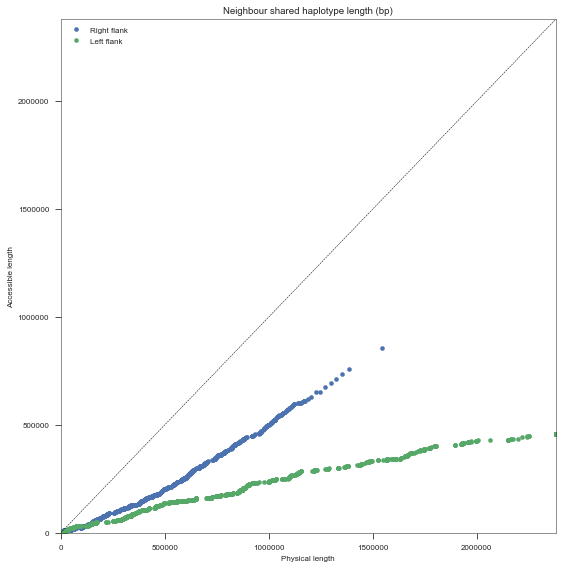

In [36]:
def nn_accessibility_diagnostics():

    # get some diagnostics on accessibility on left versus right flanks
    fig, ax = plt.subplots(figsize=(8, 8))
    x = nn_spd_right
    y = nn_spd_right_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
    x = nn_spd_left
    y = nn_spd_left_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
    ax.set_xlabel('Physical length')
    ax.set_ylabel('Accessible length')
    lim = 0, x.max()
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.legend()
    ax.set_title('Neighbour shared haplotype length (bp)')
    fig.tight_layout()
    

nn_accessibility_diagnostics()

In [37]:
# 1 cM/Mb convert to M/bp
1 / (1e2 * 1e6)

1e-08

In [38]:
# assume constant recombination rate
rr_right = 1.5e-8
# adjust recombination rate on left flank (factor derived from pairwise analysis below)
rr_left = rr_right * 0.37

# assumed mutation rate
mu_right = 3.5e-9
# adjust mutation rate on left flank (factor derived from pairwise analysis below)
mu_left = mu_right * 0.61

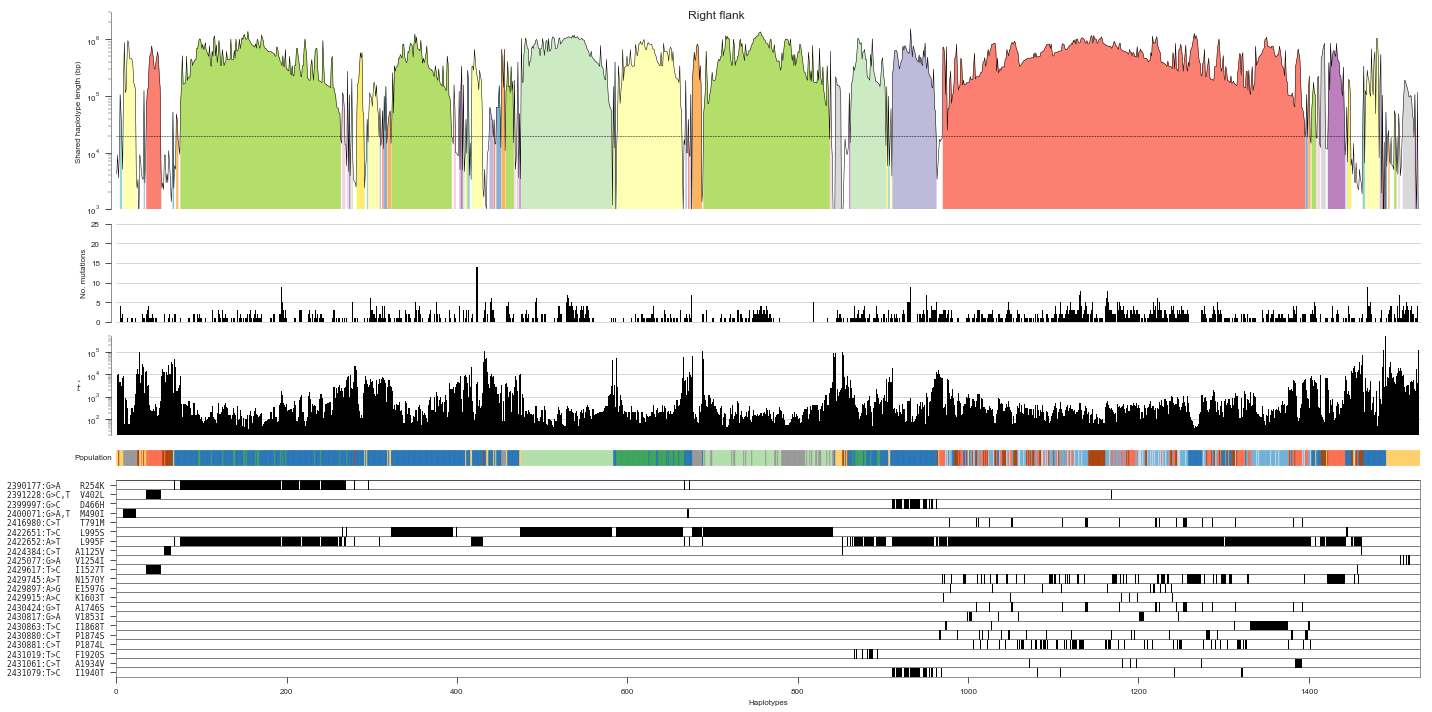

In [39]:
def plot_nn_right_flank():

    pops_right = df_haplotypes.population[nn_idx_sorted_right]
    pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]

    fig = plt.figure(figsize=(20, 10))
    hapclust.fig_neighbour_haplotype_sharing(nspd=nn_spd_right, 
                                             nspd_accessible=nn_spd_right_accessible,
                                             muts=nn_muts_right, 
                                             haps_display=haps_vgsc_missense[:, nn_idx_sorted_right],
                                             haps_display_vlbl=lbl_vgsc_missense,
                                             pop_colors=pop_colors_right,
                                             nspd_cut=2e4,
                                             nspd_ylim=(1e3, 3e6),
                                             that_ylim=(2e1, 5e5),
                                             muts_ylim=(0, 25),
                                             mu=mu_right, rr=rr_right,
                                             fig=fig)
    fig.suptitle('Right flank')
    
    
plot_nn_right_flank()

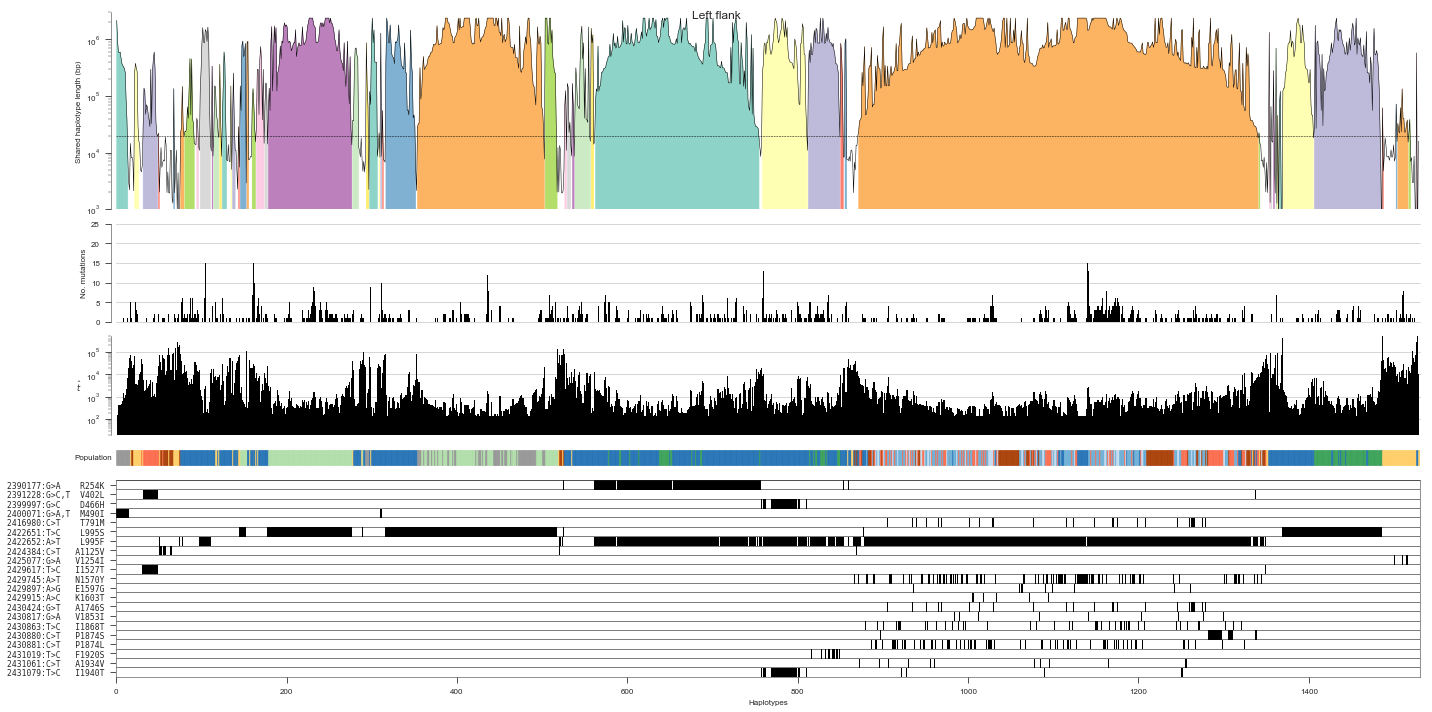

In [40]:
def plot_nn_left_flank():

    pops_left = df_haplotypes.population[nn_idx_sorted_left]
    pop_colors_left = [phase1_ar3.pop_colors[p] for p in pops_left]

    fig = plt.figure(figsize=(20, 10))
    hapclust.fig_neighbour_haplotype_sharing(nspd=nn_spd_left, 
                                             muts=nn_muts_left, 
                                             nspd_accessible=nn_spd_left_accessible,
                                             haps_display=haps_vgsc_missense[:, nn_idx_sorted_left],
                                             haps_display_vlbl=lbl_vgsc_missense,
                                             pop_colors=pop_colors_left,
                                             nspd_cut=2e4,
                                             nspd_ylim=(1e3, 3e6),
                                             that_ylim=(2e1, 5e5),
                                             muts_ylim=(0, 25),
                                             mu=mu_left, rr=rr_left,
                                             fig=fig)
    fig.suptitle('Left flank')
    
    
plot_nn_left_flank()

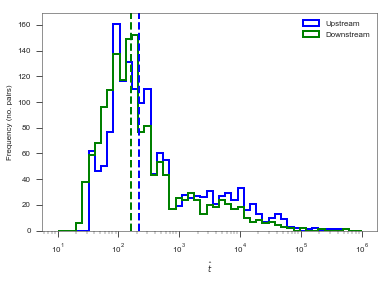

In [41]:
def nn_t_hat_diagnostics():

    # get some diagnostics on estimates of t hat on left versus right flanks

    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = nn_spd_left
    t_hat = (1 + nn_muts_left) / (2 * (nn_spd_left * rr_left + nn_spd_left_accessible * mu_left))
    ax.hist(t_hat[(nn_spd_left > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Upstream', color='b')
    ax.axvline(np.median(t_hat), linestyle='--', color='b', lw=2)
    t_hat = (1 + nn_muts_right) / (2 * (nn_spd_right * rr_right + nn_spd_right_accessible * mu_right))
    ax.hist(t_hat[(nn_spd_right > 0)], bins=np.logspace(1, 6, 50), histtype='step', lw=2, label='Downstream', color='g')
    ax.axvline(np.median(t_hat), linestyle='--', color='g', lw=2)
    ax.set_xscale('log')
    ax.set_xlabel('$\hat{t}$')
    ax.set_ylabel('Frequency (no. pairs)')
    ax.legend()
    
    
nn_t_hat_diagnostics()

## Analyse pair-wise haplotype sharing
- pw_spl = pairwise shared prefix length (number of SNPs)
- pw_spd = pairwise shared physical distance (bp)

### Setup, diagnostics and tuning

In [53]:
pw_spl_right, pw_spd_right, pw_muts_right = hapclust.pairwise_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right, jitter=False)

In [54]:
pw_spl_left, pw_spd_left, pw_muts_left = hapclust.pairwise_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left, jitter=False)

In [55]:
pw_spl_right.shape, pw_spl_left.shape

((1169685,), (1169685,))

In [56]:
pw_spd_right.min(), pw_spd_right.max(), pw_spd_left.min(), pw_spd_left.max()

(45, 1544571, 108, 2377961)

In [57]:
pw_spd_right_accessible = hapclust.haplotype_accessible_length(pw_spd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
pw_spd_left_accessible = hapclust.haplotype_accessible_length(pw_spd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

NameError: name 'pw_spd_right' is not defined

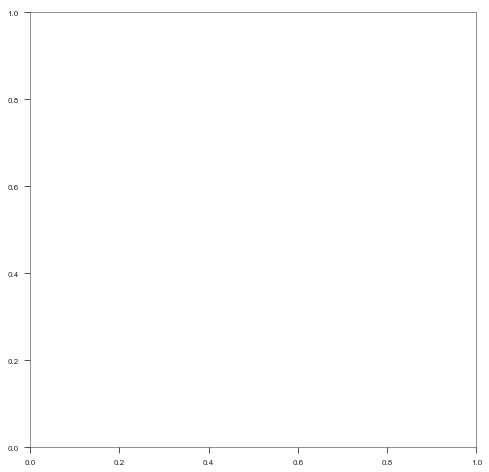

In [47]:
def pw_accessibility_diagnostics():


    # check again accessibility

    fig, ax = plt.subplots(figsize=(8, 8))
    x = pw_spd_right
    y = pw_spd_right_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
    x = pw_spd_left
    y = pw_spd_left_accessible
    ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
    ax.set_xlabel('Physical length')
    ax.set_ylabel('Accessible length')
    lim = 0, x.max()
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.legend()
    ax.set_title('Pairwise shared haplotype length')
    fig.tight_layout()
    
    
pw_accessibility_diagnostics()

check recombination rate on left vs. right flank

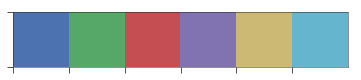

In [59]:
palette = sns.color_palette()
sns.palplot(palette);

x    0.369112
dtype: float64

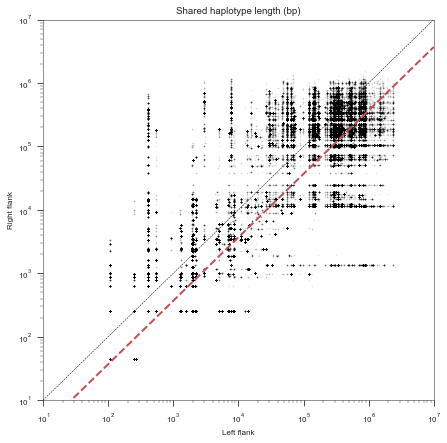

In [60]:
def pw_haplength_diagnostics():

    # compare shared haplotype length on left versus right flanks

    x = pw_TODO_left
    y = _right

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
    lim = 1e1, 1e7

    df = pandas.DataFrame({'x': x, 'y': y})
    # linear regression
    r = sfa.ols('y ~ x + 0', data=df).fit()
    # plot the regression line
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('Shared haplotype length (bp)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    return r.params


pw_haplength_diagnostics()

x    0.997601
dtype: float64

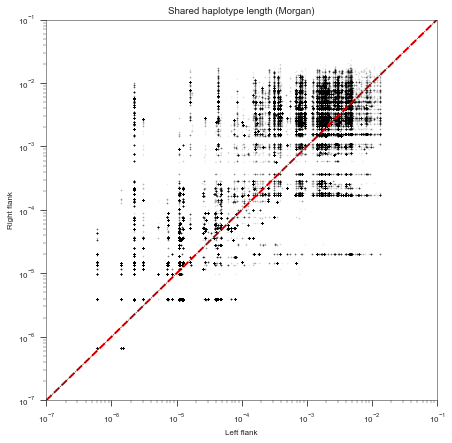

In [61]:
def pw_haplength_diagnostics_adjusted():


    # compare shared haplotype length after applying adjustment for different 
    # recombination rates on left and right flanks

    x = _left * rr_left
    y = _right * rr_right

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
    lim = 1e-7, 1e-1

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('Shared haplotype length (Morgan)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    return r.params


pw_haplength_diagnostics_adjusted()

In [62]:
# check where the heterochromatin boundary is supposed to be
phase1_ar3.tbl_chromatin

0|name,1|chrom,2|start,3|stop
CHX,X,20009764,24393108
CH2R,2R,58984778,61545105
CH2L,2L,1,2431617
PEU2L,2L,2487770,5042389
IH2L,2L,5078962,5788875


x    1.630348
dtype: float64

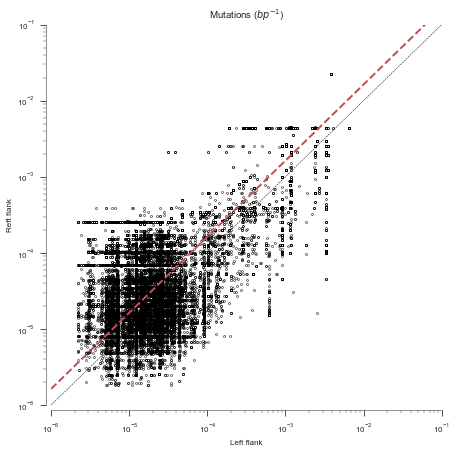

In [63]:
def pw_mutation_diagnostics():

    # check mutation rate on left versus right flank.

    x = pw_muts_left / pw_spd_left_accessible
    y = pw_muts_right / pw_spd_right_accessible
    tst = (x > 0) & (y > 0)
    x = x[tst]
    y = y[tst]

    lim = 1e-6, 1e-1
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, marker='o', markersize=2, mfc='none', mec='k', linestyle=' ')

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, linestyle='--', color='k')
    ax.set_title('Mutations ($bp^{-1}$)')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Reft flank')

    return r.params


pw_mutation_diagnostics()

x    0.994513
dtype: float64

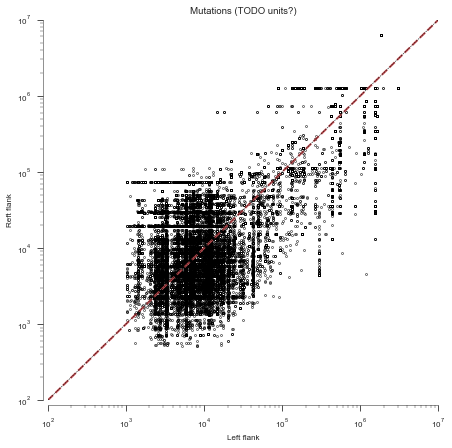

In [64]:
def pw_mutation_diagnostics_adjusted():


    # check mutations on left versus right flank after correcting mutation rate

    x = _left / (mu_left * _left_accessible)
    y = _right / (mu_right * _right_accessible)
    tst = (x > 0) & (y > 0)
    x = x[tst]
    y = y[tst]

    lim = 1e2, 1e7
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, marker='o', markersize=2, mfc='none', mec='k', linestyle=' ')

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color=palette[2], lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, linestyle='--', color='k')
    ax.set_title('Mutations (TODO units?)')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Reft flank')
    return r.params


pw_mutation_diagnostics_adjusted()

x    1.001761
dtype: float64

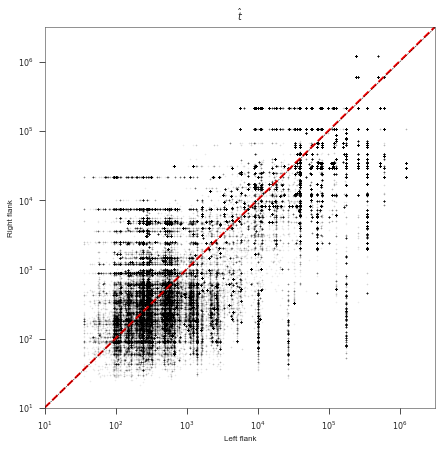

In [65]:
def pw_t_hat_diagnostics():

    # now compare estimats of t_hat on left and right flanks, using all adjustments

    pw_t_hat_left = (1 + _left) / (2 * (_left * rr_left + _left_accessible * mu_left))
    pw_t_hat_right = (1 + _right) / (2 * (_right * rr_right + _right_accessible * mu_right))
    x = np.log10(pw_t_hat_left)
    y = np.log10(pw_t_hat_right)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(x, y, marker='o', markersize=1, mfc='none', mec='k', linestyle=' ', alpha=.1)
    lim = 1, 6.5

    df = pandas.DataFrame({'x': x, 'y': y})
    r = sfa.ols('y ~ x + 0', data=df).fit()
    ax.plot(lim, [l * r.params['x'] for l in lim], linestyle='--', color='r', lw=2)

    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, 'k--')
    ax.set_xlabel('Left flank')
    ax.set_ylabel('Right flank')
    ax.set_title('$\hat{t}$')
    ticks = np.arange(lim[0], int(lim[1]) + 1)
    ticklabels = ['$10^{%s}$' % t for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    return r.params


pw_t_hat_diagnostics()

In [66]:
def compute_combined_t_hat():

    # combined both flanks
    _both = _left + _right
    pw_sgl_both = _left * rr_left + _right * rr_right
    pw_sml_both = _left_accessible * mu_left + _right_accessible * mu_right
    pw_t_hat_both = (1 + _both) / (2 * (pw_sgl_both + pw_sml_both))

In [ ]:
np.savez_compressed('../data/pairwise_haplotype_age.npz', 
                    t_hat_both=pw_t_hat_both, spd_both=_both, muts_both=_both)

# dendrogram visualisation and clustering

In [84]:
def plot_dendrogram(dist, cut_height=1e3, yscale='log', ylim=(10, 1e6), linkage_method='average',
                    n_clusters=14):
    """This function plots a dendrogram using scipy and provides some utilities for annotating clusters."""
    
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)

    fig = plt.figure(figsize=(16, 8), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, .5, 4], hspace=0)

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(
        z, no_labels=True, count_sort=True, 
        color_threshold=0, 
        above_threshold_color='k',
        ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(df_haplotypes), 200)) + [len(df_haplotypes)])
    xticks = xticklabels / len(df_haplotypes)
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')

    cluster_palette = sns.color_palette('Set3', n_colors=12)
    if cut_height:
        ax.axhline(cut_height, linestyle='--', color='k')
        # find clusters
        f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
        # compute cluster sizes
        fsz = np.bincount(f)
        # sort largest first
        fsort = np.argsort(fsz)[::-1]
        # take largest n
        fsort = fsort[:n_clusters]
        # get haplotype indices for each cluster
        clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
        clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster])
                           for cluster in clusters]
        ixs = np.argsort([min(cl) for cl in clusters_leaves])
        clusters = [clusters[i] for i in ixs]
        clusters_leaves = [clusters_leaves[i] for i in ixs]
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
#             ax.axvline(x1*10, color='k', linestyle='--')
#             ax.axvline(x2*10, color='k', linestyle='--')
            ax.fill_between([x1*10, x2*10], 0, cut_height, color=color, alpha=.4, zorder=20)
#             ax.axvspan(x1*10, x2*10, color=color, zorder=-20, alpha=.5)
            ax.text((x1*10 + x2*10) / 2, ylim[0], str(i), ha='center', va='top')
        
    ax = fig.add_subplot(gs[1], )
    sns.despine(ax=ax, left=True, bottom=True)
    pops = df_haplotypes.population[r['leaves']]
    pop_colors = [phase1_ar3.pop_colors[p] for p in pops]
    ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_yticks([])
    ax.set_ylabel('Population', rotation=0, ha='right', va='center')
    ax.set_xticks([])
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)

    ax = fig.add_subplot(gs[2])
    hapclust.plot_haplotypes(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(df_haplotypes))
    ax.set_xlabel('Haplotypes')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            color = cluster_palette[i % len(cluster_palette)]
            x1, x2 = min(cluster_leaves), max(cluster_leaves)
            ax.axvline(x1, color='k', linestyle='--', zorder=20)
            ax.axvline(x2, color='k', linestyle='--', zorder=20)
            ax.axvspan(x1, x2, color=color, zorder=20, alpha=.4)

    gs.tight_layout(fig, h_pad=0)
    return clusters

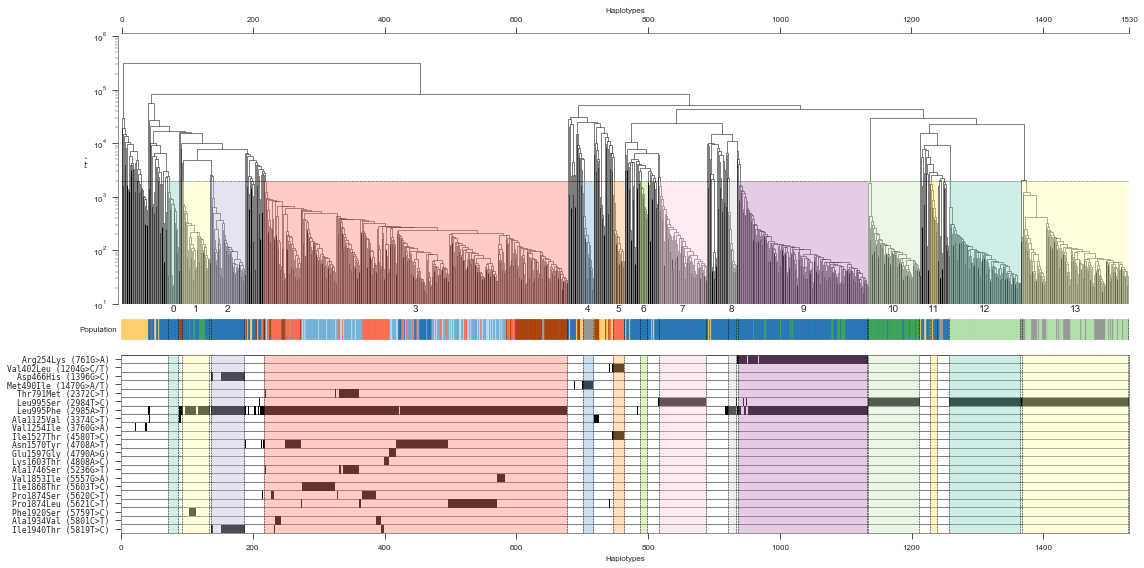

In [85]:
# canonical dendrogram we'll use for cluster analyses
clusters = plot_dendrogram(pw_t_hat_both, cut_height=2e3)

In [86]:
len(clusters)

14

In [87]:
cluster_names = {
    1 : 'F4',
    2 : 'F3',
    3 : 'F1',
    4 : 'L2',
    5 : 'L1',
    7 : 'S4/5',
    8 : 'F2',
    9 : 'F5',
    10 : 'S2',
    12 : 'S1',
    13 : 'S3'
}

# Output the haplogroup indices for use elsewhere

need to fix these names to match the Ag1000g paper;

##### new - Ag1000g

- F1 - F4
- F2 - F3
- F3 - F1
- F4 - F2
- F5 - F5

- L1 - NA
- L2 - NA

- S1 - S4/5
- S2 - S2
- S3 - S1
- S4 - S3 

In [88]:
#subset dict
clusters_good = {k: clusters[k] for k in cluster_names.keys()}

In [89]:
#check
clusters_good[5], len(clusters_good)

({2,
  9,
  11,
  34,
  38,
  75,
  135,
  149,
  157,
  170,
  186,
  208,
  226,
  237,
  251,
  261,
  266,
  269},
 11)

In [90]:
#change dict names to clusters i.e. 2 = 'F1'
for k, n in zip(list(cluster_names.keys()), list(cluster_names.values())):
    clusters_good[n] = clusters_good.pop(k)

In [91]:
#check new dict
for k, n in zip(cluster_names.keys(), cluster_names.values()):
    print(clusters[k] == clusters_good[n])

True
True
True
True
True
True
True
True
True
True
True


In [92]:
#save as pickle
import pickle
with open('../data/clust_dict.pickle', 'wb') as handle:
    pickle.dump(clusters_good, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
#check pickle
with open('../data/clust_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(clusters_good == b)

True


In [94]:
len(clusters_good.values())

11

In [95]:
#make list of all indices (values) and their cluster names (keys) in clusters_good 
all_idx = []
all_clu = []
for c in clusters_good.keys():
    for i in list(clusters_good[c]):
        all_clu.append(c)
        all_idx.append(i)
        
len(all_idx), len(all_clu)

(1220, 1220)

In [96]:
#write out text file
clus_df = pandas.DataFrame()
clus_df['cluster'] = all_clu
clus_df['haplotype'] = all_idx
clus_df.to_csv('../data/clusters.txt', sep='\t', index=False)

# cladogram figure 1a
- use our own cladogram implementation
- colour 995, 1570 mutations red, split colours of multiallelics
- add vspans for haplogroups using code from Ag1000g-fig5 - HGs are any clusters with non-syn mutations in.

In [97]:
populations = ('AOM', 'BFM', 'GWA', 'GNS', 'BFS', 'CMS', 'GAS', 'UGS', 'KES')

pop_colours = {
    'AOM': sns.color_palette('YlOrBr', 5)[4],
    'BFM': sns.color_palette('Reds', 3)[1],
    'GWA': sns.color_palette('YlOrBr', 5)[1],
    'GNS': sns.color_palette('Blues', 3)[0],
    'BFS': sns.color_palette('Blues', 3)[1],
    'CMS': sns.color_palette('Blues', 3)[2],
    'UGS': sns.color_palette('Greens', 2)[0],
    'GAS': sns.color_palette('Greens', 2)[1],
    'KES': sns.color_palette('Greys', 5)[2],
}

pop_labels = {
    'AOM': 'AO $coluzzii$',
    'BFM': 'BF $coluzzii$',
    'GWA': 'GW',
    'GNS': 'GN $gambiae$',
    'BFS': 'BF $gambiae$',
    'CMS': 'CM $gambiae$',
    'UGS': 'UG $gambiae$',
    'GAS': 'GA $gambiae$',
    'KES': 'KE'
}


In [98]:
lbl_vgsc_missense

['Arg254Lys (761G>A)',
 'Val402Leu (1204G>C/T)',
 'Asp466His (1396G>C)',
 'Met490Ile (1470G>A/T)',
 'Thr791Met (2372C>T)',
 'Leu995Ser (2984T>C)',
 'Leu995Phe (2985A>T)',
 'Ala1125Val (3374C>T)',
 'Val1254Ile (3760G>A)',
 'Ile1527Thr (4580T>C)',
 'Asn1570Tyr (4708A>T)',
 'Glu1597Gly (4790A>G)',
 'Lys1603Thr (4808A>C)',
 'Ala1746Ser (5236G>T)',
 'Val1853Ile (5557G>A)',
 'Ile1868Thr (5603T>C)',
 'Pro1874Ser (5620C>T)',
 'Pro1874Leu (5621C>T)',
 'Phe1920Ser (5759T>C)',
 'Ala1934Val (5801C>T)',
 'Ile1940Thr (5819T>C)']

In [169]:
#split colours of multiallelics
def plot_haplotypes_split(ax, h, mut_labels=None):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k', 'b'] 
    # alter rows with kdr mutations for color map to pick up
    known_muts = ['Leu995Ser (2984T>C)', 'Leu995Phe (2985A>T)']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=4)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=2)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    ax.set_yticklabels(mut_labels[::-1],family = 'monospace', fontsize=7)
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xlabel('haplotypes')
    ax.set_xticks(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    ax.xaxis.tick_bottom()

In [170]:
[cluster_names.keys()]

[dict_keys([1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13])]

In [179]:
def plot_cladogram(dist, yscale='symlog', yscale_kws=None, ylim=(10, 1e6), count_sort=True, cut_height=2e3,
                   linkage_method='average', n_clusters=14, fill_threshold=0, leaf_height=0, linewidth=2):
    
    # perform hierarchical clustering
    z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
    # needed for getting leaves in right order
    r = scipy.cluster.hierarchy.dendrogram(
        z, count_sort=count_sort, no_plot=True)

    # setup figure
    fig = plt.figure(figsize=(12, 6), )
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[6, 5, 0.4], hspace=None)
    
    # setup  vspans - find clusters
    f = scipy.cluster.hierarchy.fcluster(z, cut_height, criterion='distance')
    # compute cluster sizes
    fsz = np.bincount(f)
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    # take largest n
    fsort = fsort[:n_clusters]
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    clusters_leaves = [sorted([r['leaves'].index(i) for i in cluster]) for cluster in clusters]
    ixs = np.argsort([min(cl) for cl in clusters_leaves])
    clusters = [clusters[i] for i in ixs]
    clusters_leaves = [clusters_leaves[i] for i in ixs]
    
#----------------------------------------------------------------------------------------------------------------------

    # plot cladogram
    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, offset=3, bottom=True, top=False)
    colors = [phase1_ar3.pop_colors[p] for p in df_haplotypes.population]
    hapclust.cladogram(z, count_sort=True, colors=colors, 
                       fill_threshold=fill_threshold, leaf_height=leaf_height, 
                       plot_kws=dict(linewidth=linewidth), 
                       fill_kws=dict(linewidth=linewidth), 
                       ax=ax)
    ax.set_ylim(*ylim)
    if yscale_kws is None:
        yscale_kws = dict()
    ax.set_yscale(yscale, **yscale_kws)
    # ax.set_ylim(bottom=-1000)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, len(r['leaves']), 200)) + [len(r['leaves'])])
    xticks = xticklabels / len(r['leaves'])
    xticks = (xticks * (xmax - xmin)) + xmin
    #ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes', fontsize=9)
    ax.xaxis.set_label_position('top')
    #ax.set_ylabel('$\hat{t}$', rotation=0, ha='right')
    ax.set_ylabel('Haplotype age', fontsize=9, rotation=0, ha='right')
    ax.grid(axis='y', linestyle='--', zorder=-1e9)
    ax.axhline(cut_height, linestyle='--', linewidth=1, color='r')
    
    #legend
    allpop = list(phase1_ar3.pop_colors.keys())
    ninepop = allpop.remove('colony')
    #ninecol = [phase1_ar3.pop_colors[p] for p in ninepop]
    handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop_labels[pop]) for pop in populations]
    ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=5, prop={'size':7.5})
    
#-----------------------------------------------------------------------------------------------------------------------  
        
    # plot display haplotypes
    ax = fig.add_subplot(gs[1])
    plot_haplotypes_split(ax, haps_vgsc_missense[:, r['leaves']], lbl_vgsc_missense)
    ax.set_xlim(0, len(r['leaves']))
    ax.set_xticks([])
    ax.set_xlabel('')
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13]:
                x1, x2 = min(cluster_leaves), max(cluster_leaves)
                ax.axvline(x1, color='k', linestyle='--', zorder=20)
                ax.axvline(x2, color='k', linestyle='--', zorder=20)
                ax.axvspan(x1, x2, color='k', zorder=20, alpha=.1)
    
#-----------------------------------------------------------------------------------------------------------------------

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[2])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, 1530)
    ax_clu.set_ylim(0, 1)
    if cut_height:
        for i, cluster_leaves in enumerate(clusters_leaves):
            if i in [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13]:
                xmin, xmax = min(cluster_leaves), max(cluster_leaves)
                fraction = -20 / (xmax - xmin)
                ax_clu.annotate("", ha='left', va='center',
                                xy=(xmin, 1), xycoords='data',
                                xytext=(xmax, 1), textcoords='data',
                                arrowprops=dict(arrowstyle="-",
                                                connectionstyle="bar,fraction=%.4f" % fraction,
                                                ),
                                )
                ax_clu.text((xmax + xmin)/2, 0, cluster_names[i], va='top', ha='center', fontsize=8)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('Clusters', labelpad=8, fontsize=9)
                  
#--------------------------------------------------------------------------------------------------------------------------

    gs.tight_layout(fig, h_pad=-0.8)
    fn = '../artwork/Figure_1a_Clado.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=300, bbox_inches='tight')

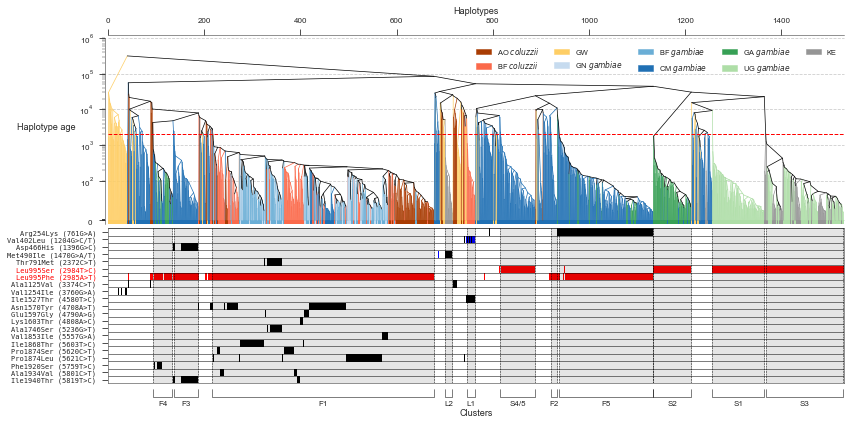

In [180]:
plot_cladogram(pw_t_hat_both, fill_threshold=0, linewidth=0.7, leaf_height=100,
               ylim=(-10, 1e6), yscale='symlog', yscale_kws=dict(linthreshy=100, linscaley=1.0, subsy=list(range(1, 10))))